## Section 1 Question 1 

The HDB Resale Portal was officially launched in Jan 2018 to streamline transaction of HDB resale
flats. This has made it easier for buyers and/or sellers to carry out transactions on their own, without
utilising a property agent’s professional services.
Using relevant data from 2017 onwards, quantify the business impact on agents. Present your
findings in the form of a data story suitable for general public consumption (e.g.: a series of
annotated charts and/or tables, a blog post-style write-up with accompanying visualizations, etc.).

In [526]:
# load dependencies

import pandas as pd 
#import pandas-profiling
import numpy as np

In [527]:
# load the recommended data sources
cea_df = pd.read_csv("../data/CEASalespersonsPropertyTransactionRecordsresidential.csv")
resale_df = pd.read_csv("../data/Resale flat prices based on registration date from Jan-2017 onwards.csv")

## CEA Sales Persons Dataset



In [528]:
# do a quick EDA of the dataset 
cea_df.describe(include='all')

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location
count,1040149,1040149,1040149,1040149,1040149,1040149,1040149,1040149,1040149
unique,29295,96,29704,5,5,4,29,29,29
top,-,JAN-2021,R043039D,CONDOMINIUM_APARTMENTS,WHOLE RENTAL,LANDLORD,-,-,-
freq,2634,20118,2558,496117,488259,457168,557275,436924,436924


In [529]:
#there are duplicated rows in the dataset
cea_df[cea_df.duplicated()]

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location
168,HAYATI BINTE JANTAN,AUG-2018,P001193F,HDB,RESALE,BUYER,YISHUN,-,-
267,CHEW KENG TUAN BENEDICT,OCT-2017,P002289Z,HDB,RESALE,BUYER,JURONG WEST,-,-
279,CHEW KENG TUAN BENEDICT,AUG-2018,P002289Z,HDB,RESALE,SELLER,JURONG WEST,-,-
284,CHEW KENG TUAN BENEDICT,JUN-2018,P002289Z,HDB,RESALE,SELLER,JURONG WEST,-,-
286,CHEW KENG TUAN BENEDICT,JAN-2018,P002289Z,HDB,RESALE,BUYER,JURONG WEST,-,-
...,...,...,...,...,...,...,...,...,...
1040136,-,DEC-2023,-,HDB,RESALE,BUYER,SEMBAWANG,-,-
1040137,-,DEC-2023,-,HDB,RESALE,BUYER,BUKIT MERAH,-,-
1040138,-,DEC-2023,-,HDB,RESALE,BUYER,BUKIT MERAH,-,-
1040140,-,DEC-2023,-,HDB,RESALE,BUYER,HOUGANG,-,-


In [530]:
cea_df.head(10) #look at the dataset head/tail I also scrolled through the data 

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location
0,SOH HUI HUA,OCT-2017,P000003I,HDB,RESALE,SELLER,YISHUN,-,-
1,SOH HUI HUA,MAR-2018,P000003I,HDB,RESALE,BUYER,KALLANG/WHAMPOA,-,-
2,SOH HUI HUA,JAN-2017,P000003I,HDB,RESALE,BUYER,YISHUN,-,-
3,SOH HUI HUA,MAY-2018,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-
4,SOH HUI HUA,NOV-2017,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-
5,SOH HUI HUA,AUG-2018,P000003I,HDB,RESALE,SELLER,SEMBAWANG,-,-
6,SOH HUI HUA,AUG-2018,P000003I,HDB,RESALE,SELLER,JURONG WEST,-,-
7,TSANG FAN WING,APR-2017,P000008Z,HDB,RESALE,SELLER,WOODLANDS,-,-
8,TAN HOON ENG,JAN-2018,P000017I,HDB,RESALE,BUYER,BUKIT MERAH,-,-
9,TAN HOON ENG,SEP-2018,P000017I,HDB,RESALE,SELLER,CENTRAL AREA,-,-


### Initial Findings and Cleanup 

After looking at the dataset I make some initial assumptions based on my findings, and also perform some clean up and preprocessing 

1) There are duplicate rows in the dataset since there are no unique primary keys for each CEA Salespersons transaction records. However since it is possible for a salesperson to close a transaction for the same property type in the same district in the same month, we treat each unique row in the dataset as a valid transaction. 

2) Some Salespersons names and Registration Numbers are not provided, however we treat these as valid transactions as well. 
3) Missing data: The dataset uses both "town", "district" and "general_location" to indicate the location of the transaction. Based on the namings, general location seems to encompass multiple towns, however multiple districts and general locations can be mapped to the same town (e.g CENTRAL AREA) too. However it seems like each district can be mapped to one general location. This corresponds to the list of postal districts I found on URA's website https://www.ura.gov.sg/Corporate/-/media/Corporate/Property/PMI-Online/List_Of_Postal_Districts.pdf 
4) I choose to use town as the broad category for location. This is also because it maps nicely to the resale price dataset. Based on the data points where district/town/general location are present, I map the unique districts to its most likely town (based on max count of the towns mapped to that town). This is by no means a perfect solution, however a decision made due to time constraints. 

In [531]:
#separate columns for transaction year and month 
cea_df[['transaction_month', 'transaction_year']]  = cea_df['transaction_date'].str.split('-', expand=True)
cea_df['town'] = cea_df['town'].replace({'QUEESTOWN': 'QUEENSTOWN'})

In [532]:
# each general location seems to be nicely mapped to a district, we know that district number and general location are unique 
cea_df[['district', 'general_location']].drop_duplicates().sort_values("district")

,district,general_location
0,-,-
7439,01,Raffles Place/ Cecil/ Marina/ People's Park
7500,02,Anson/ Tanjong Pagar
7449,03,Queenstown/ Tiong Bahru
7417,04,Telok Blangah/ Harbourfront
7428,05,Pasir Panjang/ Hong Leong Garden/ Clementi New...
14067,06,High Street/ Beach Road (part)
8405,07,Middle Road/ Golden Mile
7429,08,Little India
13429,09,Orchard/ Cairnhill/ River Valley


In [533]:
cea_df[(cea_df['town'] == '-')] #datapoints missing "town". Town will need to be mapped based on district/ general location 

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location,transaction_month,transaction_year
7444,LEE TWE JEAT,JAN-2020,P021890E,HDB,WHOLE RENTAL,LANDLORD,-,10,Ardmore/ Bukit Timah/ Holland Road/ Tanglin,JAN,2020
7483,WONG YIK LOOI,JAN-2020,R000583I,HDB,WHOLE RENTAL,LANDLORD,-,19,Serangoon Garden/ Hougang/ Punggol,JAN,2020
7590,KAN SIEW KONG RODGE,FEB-2020,P030908J,HDB,WHOLE RENTAL,LANDLORD,-,18,Tampines/ Pasir Ris,FEB,2020
7891,LEE HUP POON,JUN-2020,P028781H,HDB,WHOLE RENTAL,TENANT,-,22,Jurong,JUN,2020
7985,THAM YEW PARNG,JUL-2020,R001203G,HDB,WHOLE RENTAL,LANDLORD,-,01,Raffles Place/ Cecil/ Marina/ People's Park,JUL,2020
...,...,...,...,...,...,...,...,...,...,...,...
1037649,ANG YUH PENG,SEP-2024,R070732H,CONDOMINIUM_APARTMENTS,RESALE,SELLER,-,14,Geylang/ Eunos,SEP,2024
1037650,LI QIUSHI,SEP-2024,R070601F,CONDOMINIUM_APARTMENTS,RESALE,BUYER,-,01,Raffles Place/ Cecil/ Marina/ People's Park,SEP,2024
1040146,-,JAN-2020,-,CONDOMINIUM_APARTMENTS,WHOLE RENTAL,TENANT,-,11,Watten Estate/ Novena/ Thomson,JAN,2020
1040147,-,FEB-2020,-,CONDOMINIUM_APARTMENTS,WHOLE RENTAL,LANDLORD,-,23,Hillview/ Dairy Farm/ Bukit Panjang/ Choa Chu ...,FEB,2020


In [534]:
cea_df[(cea_df['district'] == '-')] #datapoints missing "district"

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location,transaction_month,transaction_year
0,SOH HUI HUA,OCT-2017,P000003I,HDB,RESALE,SELLER,YISHUN,-,-,OCT,2017
1,SOH HUI HUA,MAR-2018,P000003I,HDB,RESALE,BUYER,KALLANG/WHAMPOA,-,-,MAR,2018
2,SOH HUI HUA,JAN-2017,P000003I,HDB,RESALE,BUYER,YISHUN,-,-,JAN,2017
3,SOH HUI HUA,MAY-2018,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-,MAY,2018
4,SOH HUI HUA,NOV-2017,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-,NOV,2017
...,...,...,...,...,...,...,...,...,...,...,...
1040137,-,DEC-2023,-,HDB,RESALE,BUYER,BUKIT MERAH,-,-,DEC,2023
1040138,-,DEC-2023,-,HDB,RESALE,BUYER,BUKIT MERAH,-,-,DEC,2023
1040139,-,DEC-2023,-,HDB,RESALE,SELLER,WOODLANDS,-,-,DEC,2023
1040140,-,DEC-2023,-,HDB,RESALE,BUYER,HOUGANG,-,-,DEC,2023


In [535]:
all_locations_df  = cea_df[(cea_df['town'] != '-') & (cea_df['district'] != '-') & (cea_df['general_location'] != '-')]
location_df = all_locations_df[['town', 'district', 'general_location']].drop_duplicates()

In [536]:
#main issue is that one district can be mapped to multiple towns, for example the central area seems to span multiple districts, as well as more specific towns (District 02 is both CENTRAL AREA and BUKIT MERAH)

location_df[location_df['town'] == 'CENTRAL AREA']

,town,district,general_location
7439,CENTRAL AREA,01,Raffles Place/ Cecil/ Marina/ People's Park
7511,CENTRAL AREA,02,Anson/ Tanjong Pagar
7938,CENTRAL AREA,08,Little India
8405,CENTRAL AREA,07,Middle Road/ Golden Mile
8474,CENTRAL AREA,03,Queenstown/ Tiong Bahru


In [537]:
#examine how the towns have been mapped to the district 
district_town = all_locations_df.groupby(['district', 'general_location', 'town']).size()


In [538]:
district_town

district  general_location                                     town           
01        Raffles Place/ Cecil/ Marina/ People's Park          CENTRAL AREA         92
02        Anson/ Tanjong Pagar                                 BUKIT MERAH         320
                                                               CENTRAL AREA        314
03        Queenstown/ Tiong Bahru                              BUKIT MERAH        1732
                                                               CENTRAL AREA         29
                                                               QUEENSTOWN         1042
04        Telok Blangah/ Harbourfront                          BUKIT MERAH         884
05        Pasir Panjang/ Hong Leong Garden/ Clementi New Town  CLEMENTI           1914
                                                               QUEENSTOWN          222
07        Middle Road/ Golden Mile                             CENTRAL AREA        120
                                                   

In [596]:
#use the most likely mapping based on the existing data, the district that is most commonly mapped to the respective town (this is by no means a perfect solution, but just a quick one for the sake of time)
max_counts = district_town.groupby('district').idxmax()
max_mapping = district_town[max_counts]
max_mapping = max_mapping.reset_index(name='count').drop(columns=['count'])

#added in mappings that are not found 
max_mapping.loc[24] = [ '24', 'Lim Chu Kang/ Tengah', 'TENGAH'] 
max_mapping.loc[25] = [ '26', 'Upper Thomson/ Springleaf', 'BISHAN'] 
max_mapping.loc[26] = [ '06', 'High Street/ Beach Road (part)', 'KALLANG/WHAMPOA'] 
max_mapping.loc[27] = [ '09', 'Orchard/ Cairnhill/ River Valley', 'CENTRAL AREA'] 

max_mapping = max_mapping.sort_values(by = 'district').reset_index(drop = True)

In [597]:
cea_df['town'] = cea_df['town'].replace({'-': np.nan})

In [605]:
#join the district and town mapping to the original dataset to impute the missing district values 

cea_imputed = pd.merge(cea_df, max_mapping, on='district', how = 'left')

In [606]:
cea_imputed['town_x'].fillna(cea_imputed['town_y'], inplace=True)
cea_imputed.drop(columns = ['district', 'general_location_y', 'town_y', 'general_location_x'], inplace = True)
cea_imputed.rename(columns={'town_x': 'town'}, inplace = True)
cea_imputed['transaction_datetime'] = pd.to_datetime(cea_imputed['transaction_date']) 

/tmp/ipykernel_70616/805518107.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cea_imputed['town_x'].fillna(cea_imputed['town_y'], inplace=True)
/tmp/ipykernel_70616/805518107.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cea_imputed['transaction_datetime'] = pd.to_datetime(cea_imputed['transaction_date'])


In [607]:
#some data still has no town, general location or district, however it is a very small number 
len(cea_imputed[cea_imputed['town'].isnull()])

59

In [608]:
cea_imputed.drop(columns=['transaction_date'], inplace=True)

In [609]:
cea_imputed["transaction_year"] = cea_imputed["transaction_datetime"].dt.year
cea_imputed["transaction_month"] = cea_imputed["transaction_datetime"].dt.month

In [610]:
cea_imputed.to_csv('cea_processed.csv', index=False)

## Resale Price Dataset 

In [611]:
# do a quick EDA of the dataset 
resale_df.describe(include='all')

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,registration_datetime,transaction_completion
count,199101,199101,199101,199101,199101,199101,199101.000000,199101,199101.000000,199101,1.991010e+05,199101,199101
unique,97,26,7,2729,571,17,NaN,21,NaN,684,NaN,NaN,NaN
top,2024-07,SENGKANG,4 ROOM,2,YISHUN RING RD,04 TO 06,NaN,Model A,NaN,94 years 10 months,NaN,NaN,NaN
freq,3036,16430,84180,605,2880,45768,NaN,70134,NaN,1781,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,96.981188,NaN,1996.211224,NaN,5.094931e+05,2021-03-30 07:47:22.756189184,2021-05-30 05:30:41.089698048
min,NaN,NaN,NaN,NaN,NaN,NaN,31.000000,NaN,1966.000000,NaN,1.400000e+05,2017-01-01 00:00:00,2017-03-01 00:00:00
25%,NaN,NaN,NaN,NaN,NaN,NaN,82.000000,NaN,1985.000000,NaN,3.780000e+05,2019-05-01 00:00:00,2019-07-01 00:00:00
50%,NaN,NaN,NaN,NaN,NaN,NaN,93.000000,NaN,1996.000000,NaN,4.800000e+05,2021-06-01 00:00:00,2021-08-01 00:00:00
75%,NaN,NaN,NaN,NaN,NaN,NaN,112.000000,NaN,2011.000000,NaN,6.100000e+05,2023-03-01 00:00:00,2023-05-01 00:00:00
max,NaN,NaN,NaN,NaN,NaN,NaN,366.700000,NaN,2021.000000,NaN,1.600000e+06,2025-01-01 00:00:00,2025-03-01 00:00:00


In [612]:
resale_df[resale_df.duplicated()]#some duplicates but we assume that similar flats were sold during the same month 

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,registration_datetime,transaction_completion
243,2017-01,BUKIT MERAH,4 ROOM,106,HENDERSON CRES,07 TO 09,81.0,Improved,1975,57 years,470000.0,2017-01-01,2017-03-01
305,2017-01,CENTRAL AREA,3 ROOM,271,QUEEN ST,16 TO 18,68.0,Improved,1979,61 years 02 months,470000.0,2017-01-01,2017-03-01
510,2017-01,JURONG EAST,4 ROOM,265,TOH GUAN RD,04 TO 06,101.0,Model A,1998,80 years 09 months,470000.0,2017-01-01,2017-03-01
591,2017-01,JURONG WEST,4 ROOM,337A,TAH CHING RD,19 TO 21,92.0,Model A,2010,92 years 03 months,470000.0,2017-01-01,2017-03-01
672,2017-01,PASIR RIS,4 ROOM,753,PASIR RIS ST 71,01 TO 03,105.0,Model A,1996,78 years 10 months,368000.0,2017-01-01,2017-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188192,2024-10,SENGKANG,4 ROOM,329B,ANCHORVALE ST,10 TO 12,93.0,Model A,2015,89 years 11 months,695000.0,2024-10-01,2024-12-01
189465,2024-05,SENGKANG,5 ROOM,430D,FERNVALE LINK,19 TO 21,112.0,Improved,2015,90 years 01 month,770000.0,2024-05-01,2024-07-01
191068,2024-12,TAMPINES,4 ROOM,612A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,94 years 11 months,780000.0,2024-12-01,2025-02-01
195941,2024-01,YISHUN,4 ROOM,462C,YISHUN AVE 6,01 TO 03,93.0,Model A,2019,94 years 08 months,530000.0,2024-01-01,2024-03-01


In [613]:
resale_df['registration_datetime'] = pd.to_datetime(resale_df['month']) 

In [614]:
resale_df['transaction_completion'] = resale_df['registration_datetime'] + pd.DateOffset(months=2)

In [615]:
resale_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,registration_datetime,transaction_completion
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017-01-01,2017-03-01
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017-01-01,2017-03-01
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017-01-01,2017-03-01
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017-01-01,2017-03-01
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017-01-01,2017-03-01


In [616]:
resale_df.town.unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

### Quantifying Business Impact on Agents

In order to quantify the business impact on agents I will seek to answer these questions

Assumption: That the HDB Resale Portal was officially launched on 1 January 2018

Quantifying business impact in two forms 
- The number of HDB Resales transactions by Property Agents as compared to total Resale Transactions  
- The HDB resale prices before and after first quarter of 2018 

In the CEA public register the transaction date is based on the transaction completion date. 
The HDB resale prices are based on registration date of the resale application. The sale is completed roughly 8 weeks (2 months) after the registration date. Hence I will create a column to reflect transaction completion date. 

1) Comparing the year before 1 Jan 2018 and the years after, did the number of HDB RESALE transactions by property agents decrease overall? Was there a difference when the agent represented the buyer vs seller? We will need to demonstrate this as a ratio of transactions by property agents vs total HDB resale transactions made (sales?)
From resale we have total number of resale flats sold per year (per type), per town? 1 per buyer and seller 
From CEA we have total number of resale flat transacted - for buyer and seller We take those as representing the seller - means those not sold are being sold by the seller themselves and not through a property agent. "market share" 


2) Which locations had the highest proportion of property agent sales? in terms of towns? 


3) Based on the resale flat prices is this area did the HDB resale portal affect the prices of resale flats, since there is no longer a need to provide a 10% commission to the agent? Or what is the amount of commission "lost" 

4) Do we see the same trend for private housing or rentals (maybe property agents just got less popular as a whole?)


In [618]:
#Total resale flats sold by month (based on the transaction completion date of the flat)
#each transaction will have a seller and a buyer.

resales_by_month = resale_df.groupby('transaction_completion').size().reset_index(name ='resale transactions')
resales_by_month

,transaction_completion,resale transactions
0,2017-03-01,1185
1,2017-04-01,1085
2,2017-05-01,1903
3,2017-06-01,1839
4,2017-07-01,1980
...,...,...
92,2024-11-01,2205
93,2024-12-01,2140
94,2025-01-01,1935
95,2025-02-01,2123


In [638]:
#Total transactions on behalf of sellers represented by agents for HDB resale flats 
cea_hdb_resale= cea_imputed[(cea_imputed['property_type'] == 'HDB') & (cea_imputed['transaction_type'] == 'RESALE') ]
cea_transaction_month = cea_hdb_resale.groupby(['transaction_datetime', 'represented']).size().reset_index(name ='cea transactions')
cea_transactions = cea_transaction_month.pivot(index = "transaction_datetime", columns="represented", values="cea transactions").reset_index()
cea_transactions.columns.name=None

In [639]:
cea_transactions

,transaction_datetime,BUYER,SELLER
0,2017-01-01,1053,1400
1,2017-02-01,1086,1510
2,2017-03-01,935,1375
3,2017-04-01,1003,1465
4,2017-05-01,1096,1617
...,...,...,...
91,2024-08-01,1642,2389
92,2024-09-01,1710,2439
93,2024-10-01,1810,2499
94,2024-11-01,1473,2059


In [ ]:
#all of the hdb resale data has location data 

cea_hdb_resale[cea_hdb_resale.town.isnull()]

,salesperson_name,salesperson_reg_num,property_type,transaction_type,represented,town,transaction_month,transaction_year,transaction_datetime


In [640]:
sales_df = pd.merge(resales_by_month, cea_transactions, left_on='transaction_completion', right_on='transaction_datetime', how = 'left')

In [644]:
sales_df['market share cea seller'] = (sales_df['SELLER'] / sales_df['resale transactions'])*100
sales_df['market share cea buyer'] = (sales_df['BUYER'] / sales_df['resale transactions'])*100

In [645]:
sales_df

,transaction_completion,resale transactions,transaction_datetime,BUYER,SELLER,market share cea seller,market share cea buyer
0,2017-03-01,1185,2017-03-01,935.0,1375.0,116.033755,78.902954
1,2017-04-01,1085,2017-04-01,1003.0,1465.0,135.023041,92.442396
2,2017-05-01,1903,2017-05-01,1096.0,1617.0,84.971098,57.593274
3,2017-06-01,1839,2017-06-01,893.0,1360.0,73.953235,48.558999
4,2017-07-01,1980,2017-07-01,964.0,1475.0,74.494949,48.686869
...,...,...,...,...,...,...,...
92,2024-11-01,2205,2024-11-01,1473.0,2059.0,93.378685,66.802721
93,2024-12-01,2140,2024-12-01,684.0,914.0,42.710280,31.962617
94,2025-01-01,1935,NaT,NaN,NaN,NaN,NaN
95,2025-02-01,2123,NaT,NaN,NaN,NaN,NaN


In [646]:
resale_df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,registration_datetime,transaction_completion
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017-01-01,2017-03-01
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017-01-01,2017-03-01
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017-01-01,2017-03-01
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017-01-01,2017-03-01
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017-01-01,2017-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199096,2025-01,YISHUN,5 ROOM,871,YISHUN ST 81,07 TO 09,122.0,Improved,1988,62 years 04 months,738000.0,2025-01-01,2025-03-01
199097,2025-01,YISHUN,5 ROOM,851,YISHUN ST 81,10 TO 12,127.0,Improved,1988,62 years 04 months,740000.0,2025-01-01,2025-03-01
199098,2025-01,YISHUN,EXECUTIVE,352,YISHUN RING RD,04 TO 06,146.0,Maisonette,1988,62 years 07 months,1008000.0,2025-01-01,2025-03-01
199099,2025-01,YISHUN,EXECUTIVE,360,YISHUN RING RD,07 TO 09,142.0,Apartment,1988,62 years 07 months,880000.0,2025-01-01,2025-03-01


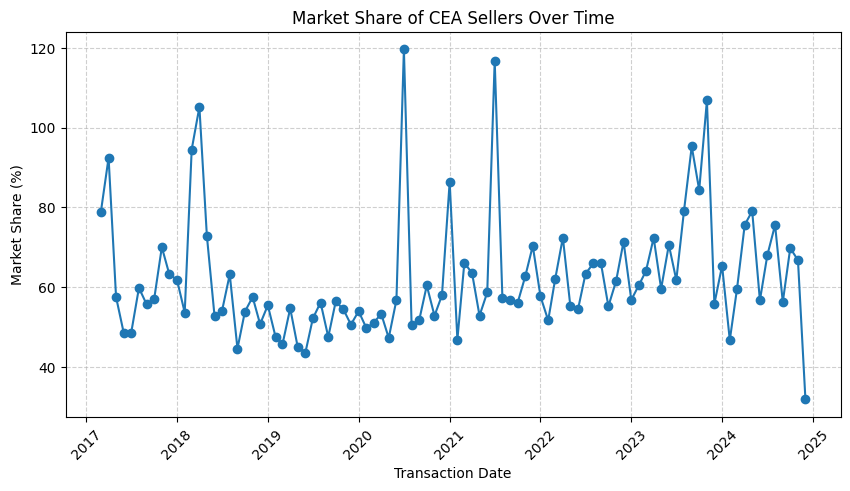

In [522]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(sales_df["transaction_datetime"], sales_df["market share cea seller"], marker="o", linestyle="-")



# Formatting the plot

plt.title("Market Share of CEA Sellers Over Time")

plt.xlabel("Transaction Date")

plt.ylabel("Market Share (%)")

plt.grid(True, linestyle="--", alpha=0.6)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability



# Display the plot

plt.show()

In [493]:
cea_hdb_resale

,salesperson_name,salesperson_reg_num,property_type,transaction_type,represented,town,transaction_month,transaction_year,transaction_datetime
0,SOH HUI HUA,P000003I,HDB,RESALE,SELLER,YISHUN,10,2017,2017-10-01
1,SOH HUI HUA,P000003I,HDB,RESALE,BUYER,KALLANG/WHAMPOA,3,2018,2018-03-01
2,SOH HUI HUA,P000003I,HDB,RESALE,BUYER,YISHUN,1,2017,2017-01-01
3,SOH HUI HUA,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,5,2018,2018-05-01
4,SOH HUI HUA,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,11,2017,2017-11-01
...,...,...,...,...,...,...,...,...,...
1040137,-,-,HDB,RESALE,BUYER,BUKIT MERAH,12,2023,2023-12-01
1040138,-,-,HDB,RESALE,BUYER,BUKIT MERAH,12,2023,2023-12-01
1040139,-,-,HDB,RESALE,SELLER,WOODLANDS,12,2023,2023-12-01
1040140,-,-,HDB,RESALE,BUYER,HOUGANG,12,2023,2023-12-01


In [ ]:
#look at the 2017 and 2018 results 


# cea_condo_resale= cea_imputed[(cea_imputed['property_type'] == 'CONDOMINIUM_APARTMENTS') & (cea_imputed['transaction_type'] == 'RESALE')  ]
# cea_condo_1718 = cea_condo_resale[cea_condo_resale['transaction_year'] < 2019]
cea_hdb_1718 = cea_hdb_resale[cea_hdb_resale['transaction_year'] < 2019]

In [452]:
df = cea_hdb_resale
df.groupby("transaction_year").size()*100

transaction_year
2017    3116200
2018    3567400
2019    3046100
2020    3252400
2021    4869900
2022    4214200
2023    4285600
2024    4238100
dtype: int64

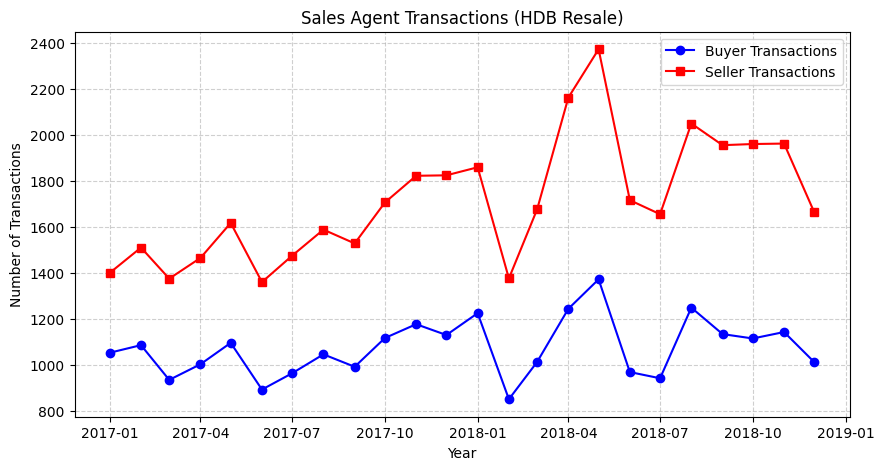

In [453]:
import pandas as pd
import matplotlib.pyplot as plt

df = cea_hdb_1718
# Count number of transactions WITH agents over time

sales_trend_split = df.groupby(["transaction_datetime", "represented"]).size().unstack()  # Convert to percentage

# Plot agent involvement trend
plt.figure(figsize=(10, 5))
plt.plot(sales_trend_split.index, sales_trend_split["BUYER"], marker="o", linestyle="-", color="blue", label="Buyer Transactions")
plt.plot(sales_trend_split.index, sales_trend_split["SELLER"], marker="s", linestyle="-", color="red", label="Seller Transactions")
plt.title("Sales Agent Transactions (HDB Resale)")
plt.xlabel("Year")
plt.ylabel("Number of Transactions")
#plt.xticks(range(df["transaction_datetime"].min(), df["transaction_datetime"].max()))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

In [ ]:
#

In [457]:
df_buyer = cea_hdb_1718[cea_hdb_1718['represented'] == 'BUYER']
df_seller = cea_hdb_1718[cea_hdb_1718['represented'] == 'SELLER']

In [471]:
top_areas = df_buyer.groupby(['town']).size().sort_values(ascending=False).reset_index()['town'].head()
bottom_areas = df_buyer.groupby(['town']).size().sort_values(ascending=False).reset_index()['town'].tail()

In [472]:
df_buyer.groupby(['town']).size().sort_values(ascending=False).reset_index()

,town,0
0,SENGKANG,2186
1,WOODLANDS,2149
2,JURONG WEST,2110
3,PUNGGOL,1931
4,TAMPINES,1832
5,YISHUN,1771
6,BEDOK,1574
7,HOUGANG,1210
8,ANG MO KIO,1188
9,CHOA CHU KANG,1047


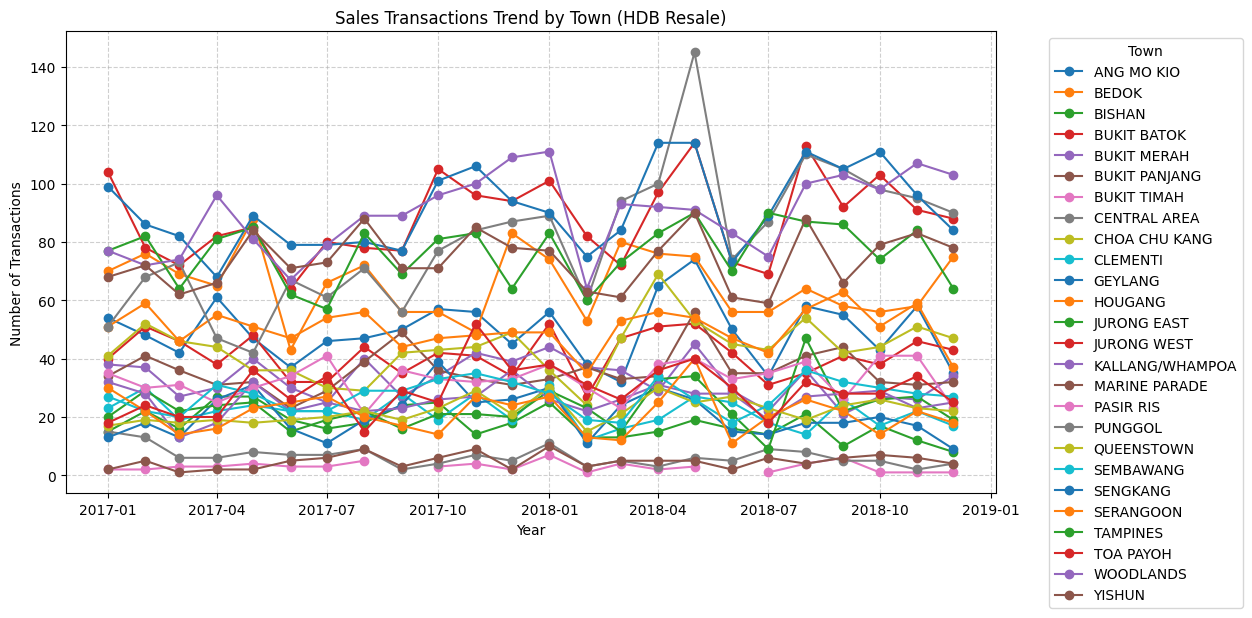

In [ ]:
df = df_buyer[df_buyer[pr]]
sales_trend_split = df.groupby(["transaction_datetime", "town"]).size().unstack()  # Convert to percentage

plt.figure(figsize=(12, 6))
for town in sales_trend_split.columns:
    plt.plot(sales_trend_split.index, sales_trend_split[town], marker="o", linestyle="-", label=town)

plt.title("Sales Transactions Trend by Town (HDB Resale)")
plt.xlabel("Year")
plt.ylabel("Number of Transactions")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Town", bbox_to_anchor=(1.05, 1), loc="upper left")



plt.show()